## Sky

`Sky` configuration dictionary. The keys specify which
components will be present; the items are lists
containing configuration dictionaries for each population of a component. 
Here we use some of the predefined models provided with `PySM` which can be accessed from the `models` module. 


In [2]:
foreground_model=dict(dgrade_nside=2**10, 
                      sky={'synchrotron' : True,
                           'dust' : True,
                           'freefree' : True,
                           'cmb' : True,
                           'ame' : True})
components=[key for key,value in foreground_model['sky'].items() if value == True]

sky_config={}
sky_config['synchrotron']=models("s1", nside)
print(sky_config)

NameError: name 'nside' is not defined

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state 

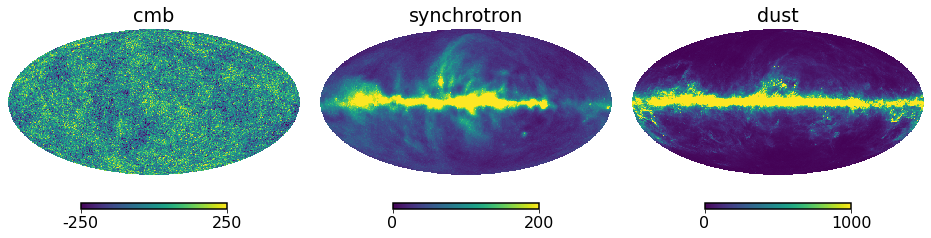

In [3]:
nside = 2**10
sky_config = {
    'synchrotron' : models("s1", nside),
    'dust' : models("d1", nside),
    'freefree' : models("f1", nside),
    'cmb' : models("c1", nside),
    'ame' : models("a1", nside),
}
sky = pysm.Sky(sky_config)

cmb = sky.cmb(nu = 95.)
synch = sky.synchrotron(nu = 30)
dust = sky.dust(nu = 500)

fig = plt.figure(figsize=(13,8))
hp.mollview(cmb[0], min = -250, max = 250, title = 'cmb', sub=131)
hp.mollview(synch[0], min = 0, max = 200, title = 'synchrotron', sub=132)
hp.mollview(dust[0], min = 0, max = 1000, title = 'dust', sub=133)
plt.show()

In [ ]:
rot_southpole = hp.Rotator(rot=[0, 90], inv=True)

import time

start = time.time()
rot = rot_southpole.rotate_map_pixel(synch[0])
end = time.time()
print(end - start)

As a test, we compute the mean and RMS of the different CMB and foreground components

In [3]:
freqs = np.logspace(np.log10(10), np.log10(600), 30)

total_mean = np.mean(sky.signal()(freqs), axis = 2)[:,0]
dust_mean = np.mean(sky.dust(freqs), axis = 2)[:,0]
synch_mean = np.mean(sky.synchrotron(freqs), axis = 2)[:,0]
ff_mean = np.mean(sky.freefree(freqs), axis = 2)[:,0]
ame_mean = np.mean(sky.ame(freqs), axis = 2)[:,0]
cmb_mean = np.mean(sky.cmb(freqs), axis = 2)[:,0]

total_rms = np.std(sky.signal()(freqs), axis = 2)[:,0]
dust_rms = np.std(sky.dust(freqs), axis = 2)[:,0]
synch_rms = np.std(sky.synchrotron(freqs), axis = 2)[:,0]
ff_rms = np.std(sky.freefree(freqs), axis = 2)[:,0]
ame_rms = np.std(sky.ame(freqs), axis = 2)[:,0]
cmb_rms = np.std(sky.cmb(freqs), axis = 2)[:,0]

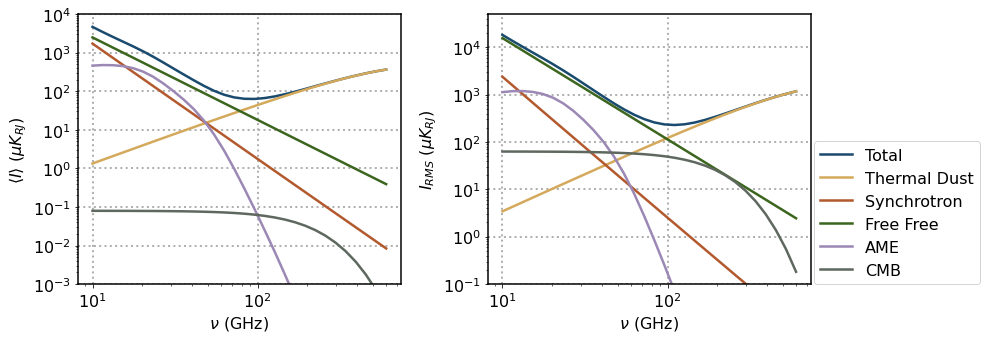

In [4]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.loglog(freqs, total_mean)
plt.loglog(freqs, dust_mean)
plt.loglog(freqs, synch_mean)
plt.loglog(freqs, ff_mean)
plt.loglog(freqs, ame_mean)
plt.loglog(freqs, cmb_mean)
plt.ylim(1e-3, 1e4)
plt.xlabel(r'$\nu$ (GHz)')
plt.ylabel(r'$\langle I \rangle$ ($\mu K_{RJ}$)')
plt.grid(linestyle='dotted', linewidth=2)

plt.subplot(1,2,2)
plt.loglog(freqs, total_rms, label='Total')
plt.loglog(freqs, dust_rms, label='Thermal Dust')
plt.loglog(freqs, synch_rms, label='Synchrotron')
plt.loglog(freqs, ff_rms, label='Free Free')
plt.loglog(freqs, ame_rms, label='AME')
plt.loglog(freqs, cmb_rms, label='CMB')
plt.legend(loc=(1.01,0))
plt.ylim(1e-1, 5e4)
plt.xlabel(r'$\nu$ (GHz)')
plt.ylabel(r'$I_{RMS}$ ($\mu K_{RJ}$)')
plt.grid(linestyle='dotted', linewidth=2)

plt.tight_layout()
plt.show()

## Rotation and survey selection

After creating maps of the galactic foreground and the CMB, we must to add them to the 3d lightcone map. The procedure can be summarized as follows

1. Produce foreground maps at the observed frequency channels
2. Rotate foreground maps so that the center of the observed footprint is at the origin of the coordinate system (hence matching the lightcone coordinates)
3. Select pixels within the survey mask and map pixel positions and frequencies onto 3d coordinates

We begin by demonstrating the rotation procedure of the healpix maps by placing the galactic south pole at the center of the observed map

/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


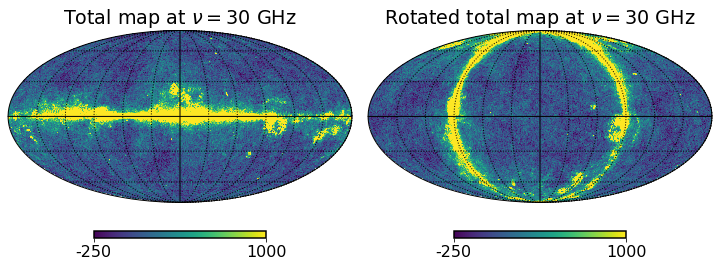

In [4]:
obs_freq=np.linspace(26, 34, 5)
tot_map=sky.signal()(obs_freq)[:,0,:]

rot_southpole = hp.Rotator(rot=[0, 90], inv=True)
tot_map_rotated=[]
for i in range(len(obs_freq)):
    tot_map_rotated.append(rot_southpole.rotate_map_pixel(tot_map[i]))

fig = plt.figure(figsize=(10,8))
hp.mollview(tot_map[2], min = -250, max = 1000, title=r'Total map at $\nu = 30$ GHz', sub=121)
hp.mollview(tot_map_rotated[2], min = -250, max = 1000, title=r'Rotated total map at $\nu = 30$ GHz', sub=122)
hp.graticule()

Compute residuals to assess the rotation precision...

In [5]:
inv_rot_southpole = hp.Rotator(rot=[0, -90], inv=True)
inv_tot_map_rotated=[]
for i in range(len(obs_freq)):
    inv_tot_map_rotated.append(inv_rot_southpole.rotate_map_pixel(tot_map_rotated[i]))

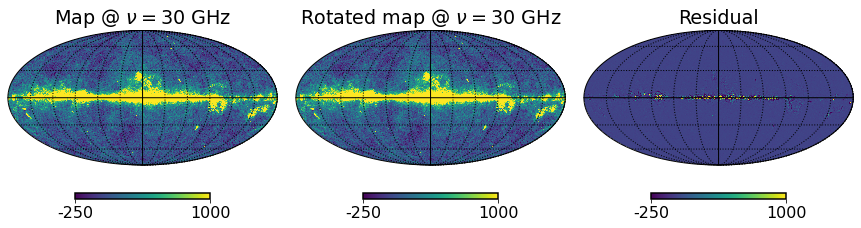

In [6]:
fig = plt.figure(figsize=(12,8))
hp.mollview(tot_map[2], min = -250, max = 1000, title=r'Map @ $\nu = 30$ GHz', sub=131)
hp.mollview(inv_tot_map_rotated[2], min = -250, max = 1000, title=r'Rotated map @ $\nu = 30$ GHz', sub=132)
hp.mollview(tot_map[2]-inv_tot_map_rotated[2], min = -250, max = 1000, title=r'Residual', sub=133)
hp.graticule()

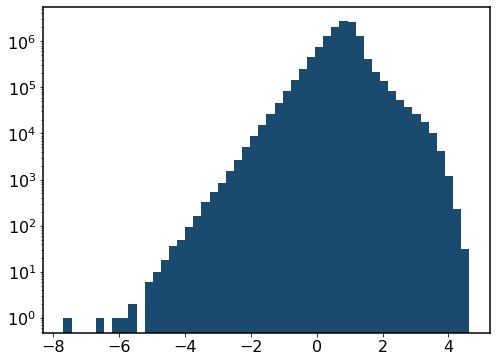

In [15]:
plt.hist(np.log10(abs(tot_map[2]-inv_tot_map_rotated[2])), bins=50, log=True)
plt.show()

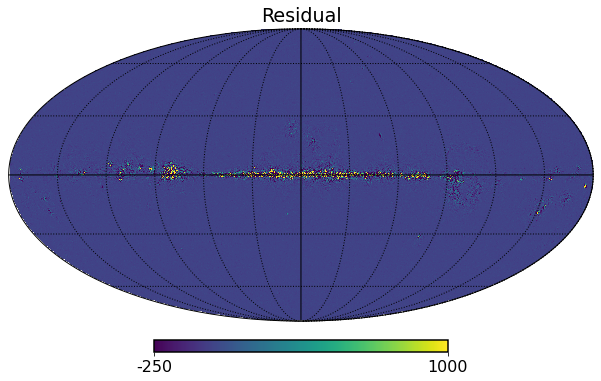

In [7]:
hp.mollview(tot_map[2]-inv_tot_map_rotated[2], min = -250, max = 1000, title=r'Residual')
hp.graticule()

We then select the region of the map within the observed cubic footprint

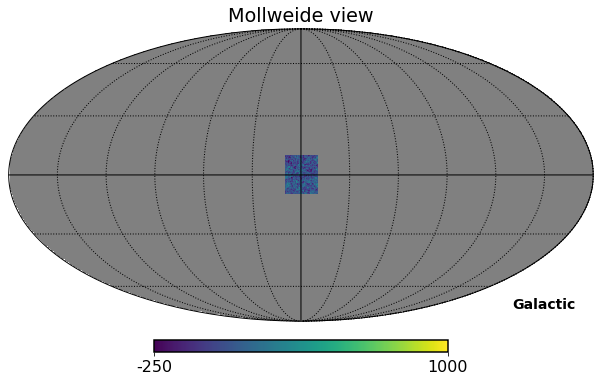

In [20]:
def tp2ra(theta, phi):    
    ra = np.rad2deg(phi)
    dec = np.rad2deg(0.5 * np.pi - theta)
    return ra, dec

def observed_mask_2d(nside, ra_min, ra_max, dec_min, dec_max):
    pix = np.arange(hp.nside2npix(nside), dtype=int)
    theta, phi = hp.pix2ang(nside, pix)
    ra, dec = tp2ra(theta, phi)

    DEC_mask=(dec>dec_min)&(dec<=dec_max)
    ra[ra>180]=ra[ra>180]-360
    RA_mask=(ra>ra_min)&(ra<=ra_max)

    mask=RA_mask&DEC_mask
    return mask

pix_mask = np.logical_not(observed_mask_2d(nside, -10, 10, -10, 10))
masked_map=np.copy(tot_map_rotated[4])
masked_map[pix_mask]=hp.UNSEEN
hp.mollview(masked_map, min = -250, max = 1000, coord='G')
hp.graticule()

In [17]:
masked_map

array([-1.6375e+30, -1.6375e+30, -1.6375e+30, ..., -1.6375e+30,
       -1.6375e+30, -1.6375e+30])

In [21]:
hp.fitsfunc.write_map('../../test_map',masked_map, coord='G', dtype=np.float32)

## Lightcone implementation

In [1]:
import sys
sys.path.append('../../preLIMinary/')
sys.path.append('/home-2/gsatopo1@jhu.edu/library/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from LIM_lightcone import paint_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pysm
from pysm.nominal import models
import healpy as hp
import time

grey='#324356'
turquoise='#54858a'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'
cmap = mpl.colors.LinearSegmentedColormap.from_list("", [grey,turquoise,yellow,yellow_orange,orange])

palette=['#1a4b6e', '#d4a95b', '#b3592e', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8.0, 6.0]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

In [6]:
def LC_params():
    h=0.678
    nu_CO=115.271*u.GHz
    zmin_CO = 2.4;zmax_CO = 2.45
    dnu=200*u.MHz
    model_params=dict(halo_lightcone_dir='/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/', 
                      lines=dict(CO_J10=True), target_line = 'CO_J10',
                      models=dict(CO_J10=dict(model_name='CO_Li16',
                                          model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      supersample=1,
                      Nmu=20,
                      dk=0.02*u.Mpc**-1,
                      do_intensity=False,
                      seed=0,
                      nside=2**12,
                      do_gal_foregrounds=True,
                      foreground_model=dict(dgrade_nside=2**10, 
                                            survey_center=[0*u.deg, 90*u.deg], 
                                            sky={'synchrotron' : True, 
                                                 'dust' : True, 
                                                 'freefree' : True, 
                                                 'cmb' : True,
                                                 'ame' : True}))
    obs_params=dict(zmin = zmin_CO-0.03, zmax = zmax_CO+0.03,
                    RAObs_min=-1*u.deg,RAObs_max=1*u.deg,
                    DECObs_min=-1*u.deg,DECObs_max=1*u.deg,
                    RA_min=-1*u.deg,RA_max=1*u.deg,
                    DEC_min=-1*u.deg,DEC_max=1*u.deg,
                    nuObs_max=nu_CO/(1+zmin_CO), nuObs_min=nu_CO/(1+zmax_CO),
                    dnu=dnu,
                    Tsys=0*u.Jy/u.sr,
                    #Tsys=0*u.K,
                    #Tsys=(45*u.K/(69.4)**0.5)*np.sqrt(4/400),
                    Nfeeds=19*2,
                    beam_FWHM=2*u.arcmin,
                    tobs=1000*u.hr,
                    linear_VID_bin=False, Tmin_VID = 1.0e-4*u.uK,
                    do_angular_smooth=True)
    obs_params.update(model_params)
    return obs_params

In [7]:
LC_CO=make_measurements(LC_params())

In [8]:
start = time.time()
CO_map=LC_CO.obs_3d_map

end = time.time()
print(end - start)

/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_158.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_159.fits
/home-2/gsatopo1@jhu.edu/scratch/MDPL2-UM-squareLC/lightcone_MDPL2UM_160.fits


/home-2/gsatopo1@jhu.edu/library/py3_env/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


343.2653992176056


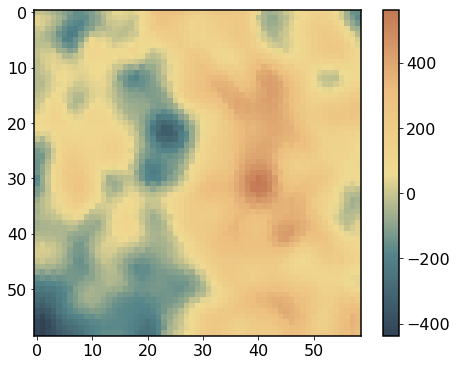

In [10]:
plt.imshow(CO_map[0,1:,1:], cmap=cmap)
plt.colorbar()

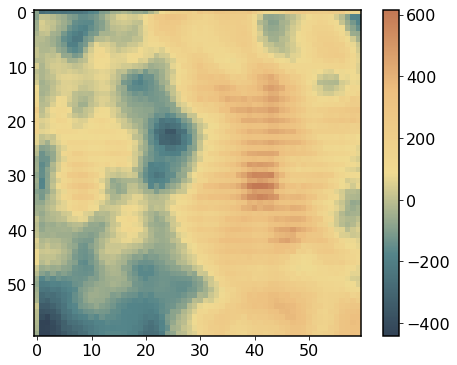

In [5]:
plt.imshow(CO_map[0,:,:], cmap=cmap)
plt.colorbar()

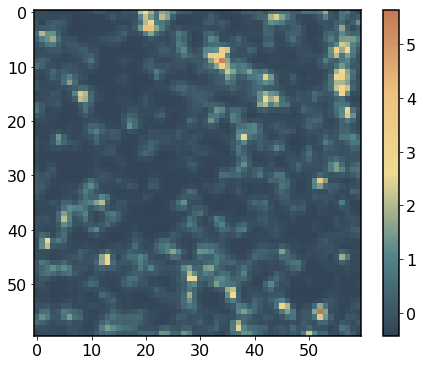

In [36]:
plt.imshow(CO_map[0,:,:], cmap=cmap)
plt.colorbar()

In [35]:
CO_map.shape

(5, 60, 60)